# Entrega Aplicando Conhecimento A2

Neste documento, que compõe a entrega necessária para o exercício A2 - Aplicando Conhecimento, os seguintes itens serão desenvolvidos:

1. Definição de linguagem de programação usada no Projeto
2. Análise exploratória da base de dados escolhida
3. Tratamento da base de dados 
4. Definição e descrição das bases teóricas dos métodos 
5. Definição e descrição de como será calculada a acurácia

## Definição de linguagem de programação usada no Projeto

Para o projeto, será utilizada a linguagem de programação Python, em virtude dos seguintes fatores:

1. Versatilidade: permite-se escrever tanto o backend quanto um REST API e frontend por meio de uma mesma linguagem, facilitando o desenvolvimento do protótipo;

2. Adequação à projetos de IA: python se tornou uma das linguagens naturalmente utilizadas para projetos envolvendo IA generativa, que é o caso deste trabalho;



## Tratamento da base de dados

Inicialmente, faz-se necessário ressaltar que a "base de dados" advém de um único documento com 179 páginas. Assim, para permitir uma análise exploratória ou qualquer outra atividade de análise, deve-se transformar o documento (dado não estruturado) em uma base de dados propriamente dita (no nosso caso, com a extração de pedaços - <i>chunks</i> - e transformação em vetores - por meio de modelos de <i>embeddings</i>).

Para isso, será utilizada a biblioteca opensource <b><a href='https://docling-project.github.io/docling/'>Docling</a></b>, que permite o processamento de textos em pdf com extração de imagens por OCR, além da biblioteca de IA generativa <a href='https://www.langchain.com/'>LangChain</a>, que permite a utilização de modelos de embeddings e de LLMs no trabalho. 

(Para maiores informações, acessar o website das bibliotecas).

A ideia da preparação de dados, neste caso, é permitir que o texto (dado não estruturado) seja transformado em um conjunto de vetores de valores (embeddings) para, posteriormente, ser usado por um sistema ou modelo para responder perguntas dos usuários.

#### Transformação do .pdf em um markdown

Através dessa transformação, o documento poderá ser posteriormente quebrado em seções, facilitando a criação de <i>chunks</i> para a criação da vector store. 



In [ ]:
from docling.document_converter import DocumentConverter

source = "BalancoGeralEstadoRS.pdf"

converter = DocumentConverter()
result = converter.convert(source)

In [ ]:
result.document.export_to_markdown()[:1000]

#### Transformação do markdown em chunks 

Após a transformação em markdown, permite-se que a biblioteca langchain consiga dividir o documento em chunks.

In [ ]:
from langchain_text_splitters import MarkdownHeaderTextSplitter

headers_to_split_on = [
            ("#", "Header_1"),
            ("##", "Header_2"),
            ("###", "Header_3")
        ]

splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

chunks = splitter.split_text(result.document.export_to_markdown())

chunks[50]


In [ ]:
print('O documento possui', len(chunks), 'chunks de tamanho médio', round(sum(len(chunk.page_content) for chunk in chunks) / len(chunks), 2), 'caracteres')

#### Transformação dos chunks em vetores (embeddings)

Por fim, realiza-se a transformação dos chunks em vetores, e armazena-os para posterior utilização.

<i><b>Observação: para este tratamento, é necessário o uso de uma API key da OpenAI. Esta API KEY não estará disponível no repositório, sendo necessário criar um arquivo .env com a seguinte chave:

OPENAI_API_KEY: {chave_pessoal_da_openai}</b></i>


In [ ]:
# Importação do modelo de embeddings
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
from langchain_chroma import Chroma

load_dotenv()

# Configuração do modelo de embeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Criação da vector store
vector_store = Chroma(
    collection_name="balanco_geral",
    embedding_function=embeddings,
    persist_directory="src/vectorStore", 
)

vector_store.add_documents(chunks)




Com isso, a Vector Store (que representa a base de dados) está pronta. 

## Análise Exploratória de Dados


### Entendimento dos dados

Conforme mencionado no arquivo "Projeto Aplicado II.pdf", os dados a serem utilizados são extraídos de um mesmo documento ("Balanço Geral do Estado do Rio Grande do Sul 2024").


In [ ]:
print('O documento possui', len(chunks), 'chunks de tamanho médio', round(sum(len(chunk.page_content) for chunk in chunks) / len(chunks), 2), 'caracteres')

Foram divididos em 156 chunks, representando possíveis 156 capítulos e/ou seções. 

Optou-se por criar um dataframe da biblioteca pandas para melhor explorar os dados. 

In [ ]:
import pandas as pd 

estatisticas_chunks = pd.DataFrame(
    {
        'titulo': [chunk.metadata.values() for chunk in chunks],
        'tamanho': [len(chunk.page_content) for chunk in chunks],    # Extração de quantidade de caracteres
        'chunk': [chunk.page_content for chunk in chunks]
    }
)


In [ ]:
estatisticas_chunks.sample(5)

In [ ]:
estatisticas_chunks.sort_values(by='tamanho', ascending=False).head(10)

In [ ]:
estatisticas_chunks.tamanho.describe()

Percebe-se acima que há muitos chunks com elevada quantidade de caracteres, em especial o Sumário.
Além disso, chama a atenção um chunk com 14 caracteres.

In [ ]:
estatisticas_chunks.query('tamanho < 1000').head(5)

Como esperado, o chunk de 14 caracteres era uma imagem que acabou não sendo processada. Observando manualmente o Balanço Geral, contudo, percebeu-se ser só uma imagem figurativa, sem valor para o trabalho.

In [ ]:
import matplotlib.pyplot as plt

estatisticas_chunks.tamanho.hist(bins=100)
plt.title('Histograma do tamanho dos chunks')
plt.xlabel('Tamanho')
plt.ylabel('Frequência')
plt.show()



Analisando a frequência das palavras, verifiquemos as mais frequentes nos chunks e em geral.

In [ ]:
from collections import Counter
import re

def extrair_palavras_mais_frequentes(texto, n=10):
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúàâêôãõç\s]', '', texto)
    palavras = texto.split()
    stopwords = {"a", "o", "e", "de", "do", "da", "em", "um", "uma", "que", "para", 
                 "no", "na", "os", "as", "com", "por", "se", "ao", "dos", "das"}
    palavras_filtradas = [p for p in palavras if p not in stopwords]
    contagem = Counter(palavras_filtradas)
    
    return contagem.most_common(n)


for idx, row in estatisticas_chunks.iterrows():
    palavras = extrair_palavras_mais_frequentes(row['chunk'])
    estatisticas_chunks.at[idx, 'palavras_mais_frequentes'] = palavras

textao = ' '.join([chunk for chunk in estatisticas_chunks.chunk])
palavras_mais_frequentes = extrair_palavras_mais_frequentes(textao, n=100)

In [ ]:
palavras_mais_frequentes

## Definição e descrição das bases teóricas dos métodos 

### Engenharia de Dados

A **Engenharia de Dados** é uma disciplina que se concentra no design, construção e manutenção de sistemas de dados robustos e escaláveis. Ela envolve, entre outros conceitos:

- **Pipeline de Dados**: Sequência de processos que extraem, transformam e carregam dados (ETL/ELT)
- **Arquitetura de Dados**: Estrutura organizacional que define como os dados fluem através de um sistema
- **Data Lake**: Repositório que armazena dados brutos em seu formato nativo


#### <i>Relação do trabalho com a disciplina

No caso do trabalho em questão, utilizou-se um pipeline básico com as bibliotecas docling e langchain para construir um equivalente a um Data Lake, aqui chamado de Vector Store, com uma arquitetura voltada para a utilização na modelagem e implementação do sistema baseado em LLM.</i>




### Inteligência Artificial (IA)

A **Inteligência Artificial** é um campo da ciência da computação que visa criar sistemas capazes de realizar tarefas que normalmente requerem inteligência humana:

- **Machine Learning (ML)**: Algoritmos que aprendem padrões a partir de dados sem programação explícita
- **Deep Learning**: Subcampo do ML que usa redes neurais com múltiplas camadas
- **Processamento de Linguagem Natural (NLP)**: Capacidade de máquinas entenderem e processarem linguagem humana
- **Computer Vision**: Capacidade de máquinas interpretarem e analisarem informações visuais
- **Sistemas de Recomendação**: Algoritmos que sugerem itens relevantes para usuários
- **IA Generativa**: Modelos que podem criar conteúdo novo (texto, imagens, código) baseado em padrões aprendidos


#### <i> Relação do trabalho com a disciplina

No caso deste trabalho, utilizou-se ferramentas de visão computacional e de machine learning, tornadas abstradas na biblioteca docling, de processamento de linguagem natural (para exploração dos dados e embeddings), além de planejar o uso de IA generativa para os próximos passos.</i>


### Processamento de Dados Não Estruturados

**Dados não estruturados** são informações que não seguem um formato predefinido ou modelo de dados específico:

- **Textos**: Documentos, emails, posts em redes sociais, artigos
- **Imagens**: Fotos, diagramas, gráficos, documentos digitalizados
- **Áudio**: Gravações de voz, música, podcasts
- **Vídeo**: Gravações, transmissões ao vivo, conteúdo multimídia
- **Dados Semi-estruturados**: JSON, XML, logs de sistema

**Técnicas de Processamento**:
- **OCR (Optical Character Recognition)**: Conversão de imagens com texto em texto editável
- **Web Scraping**: Extração automatizada de dados de websites
- **Análise de Sentimento**: Determinação da opinião ou emoção em textos
- **Extração de Entidades**: Identificação de pessoas, lugares, organizações em textos
- **Embeddings**: Representação vetorial de textos para análise semântica

#### <i>Relação do trabalho com a disciplina

Conforme já mencionado, a biblioteca Docling utiliza em seu baixo nível instrumentos de OCR e outras técnicas para a transformação dos dados não estruturados. O resultado se torna equivalente a dados semi-estruturados, aptos a receberem uma representação vetorial (embeddings). </i>



### Tópicos de Banco de Dados

Os **Bancos de Dados** são sistemas organizados para armazenar, gerenciar e recuperar informações:

#### **Bancos Relacionais (SQL)**:
- **ACID**: Atomicidade, Consistência, Isolamento, Durabilidade
- **Normalização**: Processo de organização de dados para reduzir redundância
- **Índices**: Estruturas que aceleram consultas
- **Transações**: Operações que mantêm integridade dos dados
- **Views**: Representações virtuais de dados

#### **Bancos NoSQL**:
- **Documentos**: MongoDB, CouchDB (armazenam documentos JSON/BSON)
- **Chave-Valor**: Redis, DynamoDB (armazenam pares chave-valor)
- **Colunas**: Cassandra, HBase (armazenam dados em colunas)
- **Grafos**: Neo4j, Amazon Neptune (armazenam relacionamentos)

#### **Conceitos Avançados**:
- **Data Warehousing**: Repositórios otimizados para análise
- **Data Mining**: Descoberta de padrões em grandes volumes de dados
- **OLAP vs OLTP**: Processamento analítico vs transacional
- **Sharding**: Divisão de dados em múltiplos servidores
- **Replicação**: Cópias de dados para alta disponibilidade
- **Backup e Recovery**: Estratégias de proteção e recuperação de dados



### Resumo da Integração das Disciplinas no Projeto

Este projeto integra todas essas áreas ao:
1. **Processar dados não estruturados** (PDF) usando técnicas de NLP e OCR
2. **Aplicar IA** através de embeddings e modelos de linguagem para análise semântica
3. **Utilizar conceitos de banco de dados** na criação de vector stores para busca eficiente
4. **Implementar engenharia de dados** no pipeline de transformação e armazenamento dos dados


## Definição e descrição de como será calculada a acurácia

O trabalho possui como desafio <i>"tornar informações complexas e densas compreensíveis e úteis para o cidadão comum, fortalecendo o exercício do controle social e promovendo uma gestão pública mais aberta e participativa" </i> (Projeto Aplicado II, p. 8).

Isso foi reescrito no objetivo de criar <i>"um  ChatBOT  interativo,  capaz  de interpretar o Balanço Geral do Estado e demais documentos oficiais, respondendo a consultas  de  usuários sem recorrer  a  terminologia  técnica, de  forma clara e contextualizada."</i> (Projeto Aplicado II, p. 8).

Uma métrica para o cálculo da acurácia, então, deve levar em conta esse objetivo.


A despeito do termo acurácia não ser o melhor conceito a ser aplicado ao projeto, propõe-se que a métrica de avaliação seja a seguir:

<i><b>Compreensividade</b></i>: quantidade de respostas que puderam ser compreendidas pelos usuários em relação ao total.


Por ser uma métrica de custo elevado de obtenção (dado que não será fácil obter respostas de usuários finais, em especial daqueles que não possuem contato direto com códigos - tecnologia - nem com a matéria contábil), propõe-se a utilização de um <i>proxy</i>:

<i><b>Compreensividade Artificial</b</i>: quantidade de respostas que puderam ser compreendidas por LLMs com prompts delimitantes em relação ao toal.


Neste caso, <i>prompt delimitante</i> é um prompt que atribui uma personalidade para a LLM e restringe expressamente as respostas e o entendimento baseado no nível de conhecimento esperado daquela personalidade. Por exemplo:


Prompt Estruturante de Enfermeiro:

" Você é um ator artístico dedicado. Seu objetivo é representar fielmente um papel de uma pessoa, a fim de que conseguir expressar qual seria a reação dessa pessoa a uma determinada informação.

Restrinja seu entendimento sobre a resposta e em relação ao mundo ao que seria esperado de uma pessoa na mesma situação a que te for dada. Não fuja desta ordem.

Você receberá um papel e deverá dar feedback a uma determinada frase/texto, retornando uma avaliação de 1 a 5 de compreensividade e a justificativa, conforme os graus a seguir:

1. Não compreendeu nada;
2. Texto de difícil compreensão
3. Texto normal, é capaz de entender 
4. Texto relativamente adequado ao seu conhecimento
5. Texto perfeitamente compreendido por ter usado termos usuais no seu dia a dia

Exemplos:

Papel: Seu nome é Amanda Sardinha, você é enfermeira no Hospital Central do Rio Grande do Sul. Você nunca teve contato com linguagem de programação nem com qualquer outra matéria que não fosse relacionada a sua vida profissional. Você gosta de correr e ver séries, e sai com os amigos para balada.

Texto: "O crescimento da dívida com a União se deve ao esquema de postergação e refinanciamento  parcial  das  parcelas  possibilitado  pelo  Regime  de  Recuperação  Fiscal  (RRF)  e, sobretudo, à correção monetária do saldo devedor pelo CAM (coeficiente de atualização monetária),  utilizada  para  corrigir  o  saldo  devedor  até  o  mês  de  junho.  A  partir  de  julho, com a entrada em vigor da LC 206/2024, o saldo devedor passou a ser atualizado pelo IPCA. Além disso, a LC 206/2024 suspendeu o pagamento da dívida com a União por 36 meses e  determinou  juro  zerado  nesse  período.  Ao  fim  do  período  previsto,  pela  regra  atual, a atualização do saldo devedor voltará a ser realizada por meio da CAM"

Feedback: {"compreensividade": 1, "justificativa": "Eu, como Amanda, não compreendo o que seja Regime de Recuperação Fiscal, nem o que seria LC. Além disso, o texto é confuso para mim."}


Papel: Seu nome é Amanda Sardinha, você é enfermeira no Hospital Central do Rio Grande do Sul. Você nunca teve contato com linguagem de programação nem com qualquer outra matéria que não fosse relacionada a sua vida profissional. Você gosta de correr e ver séries, e sai com os amigos para balada.

Texto: "A dívida do Estado com o resto do Brasil (União) foi sendo postergada e refinanciada, e aumentou à cada refinanciamento por causa da aplicação de juros e correção monetária por um índice específico (CAM) até junho. Em julho, entrou uma lei que permitiu que a correção monetária fosse feita usando outro índice (IPCA), além de outra lei ter suspendido os pagamentos por 36 meses, com juros zeros enquanto durasse a suspensão. Ao final desse período, os juros vão voltar a ser calculados pelo índice inicial (CAM)."

Feedback: {"compreensividade": 3, "justificativa": "Eu, como Amanda, pude compreender que o Estado está em dívida com a União e que houve uma mudança da forma de calcular os juros no período. Mas ainda resta confuso sobre o que isso significa na prática."}

"



A despeito do proxy não ser perfeito, é uma forma de mensurar quando o sistema estiver razoavelmente pronto para uma anotação mais cara (utilização de usuários finais). A expectativa é que seja montado um dataset de avaliação, contendo diversas perguntas sobre o balanço, e que cada uma das respostas tenha avaliação de 5 a 10 personalidades distintas, obtendo-se a métrica (Compreensividade Artificial) pela média das notas. 





## Modelagem e Aplicação do Método Analítico

Para cumprir com o objetivo, considerando já ter sido feita a análise do entendimento do negócio (ver <i>Projeto Aplicado II.pdf</i>) e a preparação dos dados (ver <i>Tratamento da base de dados</i>), segue-se com a construção de um modelo/arquitetura para consumir os dados e responder às perguntas do usuário final. 

Uma arquitetura para solucionar este problema:

1. Deve receber a mensagem do usuário;
2. Deve identificar os dados do usuário de mensagens anteriores. Caso contrário, deverá enviar solicitação dessas informações;
3. Deve analisar os dados do usuário (nível de conhecimento técnico)
4. Deve adicionar um contexto à mensagem do usuário
5. Deve enviar a pergunta para algum modelo (endpoint) 
6. Deverá retornar a mensagem ao usuário, e aguardar nova iteração


Para construir essa solução, pretende-se usar:

1. Modelo de Linguagem (LLM): gpt-4o-mini
2. Biblioteca <a href='https://www.langchain.com/'>LangChain</a>/<a href='https://langchain-ai.github.io/langgraph/'>LangGraph</a> 
3. Plataforma <a href=https://huggingface.co/>Hugging.co</a>
4. Biblioteca <a href='https://www.gradio.app/'>Gradio</a>


#### Sistema

O sistema está disponível em <a href='https://huggingface.co/spaces/JimmyAFTE/chatbot-balanco-geral-rs'>ChatBOT - Balanço Geral do RS</a>



**Arquitetura do Sistema**

O sistema é baseado em uma arquitetura de Agent AI (agente de inteligência artificial) que combina múltiplos componentes para processar perguntas sobre o Balanço Geral do Estado do Rio Grande do Sul. A arquitetura segue um fluxo de processamento em etapas:

1. **Interface de Usuário (Gradio)**: A interface web é construída com a biblioteca Gradio, permitindo interação conversacional através de um chatbot. O componente `gr.Chatbot` mantém o histórico da conversa e o componente `gr.Textbox` recebe as perguntas do usuário.

2. **Camada de Processamento**: A função `chat()` recebe a mensagem do usuário e invoca o agente LangChain através do método `agent.invoke()`. O agente processa a mensagem dentro de um contexto de thread específico (thread_id: "1"), mantendo a continuidade da conversa.

3. **Agente LangChain**: O agente é responsável por orquestrar o fluxo de processamento, incluindo a recuperação de informações relevantes do contexto do Balanço Geral e a geração de respostas adaptadas ao nível técnico do usuário.

4. **Sistema de Prompts**: O arquivo `prompts.py` define o prompt principal do sistema (`MAIN_SYSTEM_PROMPT`) que estabelece as diretrizes de comportamento do assistente. O prompt instrui o modelo a:
    - Identificar o nível de conhecimento técnico do usuário (leigo, técnico, gestor, etc.)
    - Adaptar a linguagem e complexidade da resposta ao perfil identificado
    - Basear-se exclusivamente no contexto fornecido (documentos oficiais)
    - Solicitar esclarecimentos quando necessário para identificar o perfil do usuário
    - Estruturar respostas com resumo principal, explicação complementar e referência de origem

**Fluxo de Processamento**

1. **Entrada**: O usuário digita uma pergunta na interface Gradio
2. **Processamento**: A mensagem é encapsulada em um `HumanMessage` e enviada ao agente LangChain
3. **Contextualização**: O agente recupera informações relevantes do contexto do Balanço Geral
4. **Análise**: O sistema analisa o nível técnico do usuário com base no vocabulário e conteúdo da pergunta
5. **Geração**: O modelo gera uma resposta adaptada ao nível identificado
6. **Saída**: A resposta é retornada ao usuário através da interface Gradio

**Características Principais**

- **Adaptação de Linguagem**: O sistema ajusta automaticamente o nível técnico das respostas
- **Contexto Persistente**: Mantém o histórico da conversa através de threads
- **Baseado em Documentos**: Respostas fundamentadas exclusivamente em documentos oficiais
- **Interatividade**: Solicita esclarecimentos quando necessário para melhor compreensão do usuário

#### Avaliação 

À partir do descrito na definição de como seria calculada a acurácia, optou-se por criar um subsistema de verificação da compreensividade. 

As personas usadas são:

##### **1. Cidadão Leigo - Aposentado**
- **Perfil:** João Silva, 68 anos, aposentado, ensino médio incompleto
- **Características:** Nunca trabalhou com finanças públicas, tem dificuldade com termos técnicos, prefere explicações simples e analogias do cotidiano
- **Expectativa de compreensão:** Precisa de linguagem muito simples, sem jargões técnicos, com exemplos práticos

##### **2. Jornalista Local**
- **Perfil:** Maria Santos, 35 anos, jornalista de economia local, graduada em comunicação
- **Características:** Conhece termos econômicos básicos, precisa de informações claras para reportagens, foca no impacto social
- **Expectativa de compreensão:** Entende conceitos econômicos gerais, mas precisa de explicações sobre terminologia contábil específica

##### **3. Estudante Universitário**
- **Perfil:** Pedro Costa, 22 anos, estudante de administração pública, 6º semestre
- **Características:** Conhece conceitos básicos de administração e contabilidade, curioso, quer entender detalhes técnicos
- **Expectativa de compreensão:** Pode lidar com terminologia técnica, mas precisa de explicações didáticas e contextualização

##### **4. Contador Público**
- **Perfil:** Ana Rodrigues, 45 anos, contadora com 20 anos de experiência, especialista em contabilidade pública
- **Características:** Domina terminologia contábil e financeira, conhece legislação, precisa de informações precisas e detalhadas
- **Expectativa de compreensão:** Pode processar informações técnicas complexas, mas precisa de precisão e referências normativas

##### **5. Vereador Municipal**
- **Perfil:** Carlos Mendes, 52 anos, vereador há 8 anos, formado em direito
- **Características:** Conhece aspectos legais e políticos, precisa entender impacto orçamentário, foca em accountability
- **Expectativa de compreensão:** Entende conceitos jurídicos e políticos, mas precisa de explicações sobre aspectos contábeis específicos


##### Criando as Personas

In [1]:
PERSONA_PROMPT = """
Você é um usuário representando a seguinte persona:

{persona_description}

Você está conversando com um agente de IA que responde perguntas sobre o Balanço Geral do Estado do Rio Grande do Sul. 
Seu objetivo é interagir de forma natural e realista, como se fosse realmente essa persona, tentando compreender ao máximo o conteúdo.

Siga este protocolo:

1. **Aja como a persona**, levando em conta:
   - Seu nível de escolaridade e familiaridade com temas técnicos.
   - Seu estilo de comunicação (ex.: mais informal, com dúvidas práticas, sem usar jargões técnicos).
   - Suas limitações reais de compreensão.

2. **Quando receber uma resposta do agente**, reflita sobre:
   - O que você entendeu claramente.
   - O que ficou confuso.
   - O que você gostaria de entender melhor.

3. Se você **não entendeu bem**, peça explicações adicionais, exemplos simples ou repetições em outras palavras.
4. Se você **entendeu parcialmente**, faça perguntas para esclarecer pontos específicos.
5. Se você **entendeu bem**, faça perguntas complementares, com base no seu interesse típico (ex.: “e isso afeta a população de que forma?” para um cidadão leigo).
6. Não demonstre conhecimento técnico que a persona não teria naturalmente.

Regras adicionais:
- Suas respostas devem parecer conversas humanas curtas e naturais, com dúvidas, hesitações ou tentativas de reformular.
- Não pule para o final da conversa sem explorar a pergunta.
- Não aceite tudo de forma passiva — demonstre interesse em entender.
- Não afirme algo. Busque aprender e não responder algo. 

Pergunta inicial: {question}

Histórico da conversa: {conversation_history}
"""


PERSONA_PROMPT_EVALUATION = """
Você é um usuário representando a seguinte persona:

{persona_description}

Analise o histórico da conversa entre você e um agente de IA que explicou algo sobre o Balanço Geral do Estado do Rio Grande do Sul.

Seu objetivo agora é **avaliar seu próprio nível de compreensão** — isto é, o quanto **você, como persona**, entendeu de fato o conteúdo após a troca de mensagens.

Use a escala a seguir:
1 = Não entendi nada (resposta confusa ou técnica demais)
2 = Entendi um pouco, mas ainda tenho dúvidas principais
3 = Entendi razoavelmente, mas alguns detalhes ficaram confusos
4 = Entendi bem e consigo explicar para alguém com alguma dificuldade
5 = Entendi completamente e me senti muito confortável com a explicação

Dê uma nota honesta com base na persona — se a resposta teve muitos termos técnicos ou ficou complexa, **a nota deve ser mais baixa**.

**Retorne apenas a nota numérica (1 a 5), sem explicações.**

Pergunta inicial: {question}
Histórico da conversa: {conversation_history}
"""


In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage  
from typing import TypedDict, List
from chatbot_balanco_geral_rs.src.agents import agent
from dotenv import load_dotenv

load_dotenv()

N_ITERACOES = 3 # Definido para fazer testes até 3 iterações

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

class ConversationState(TypedDict):
    persona_description: str
    messages: List[list]
    turn: int
    final_evaluation: str

def system_agent(state: ConversationState, thread_id: str = '2'):
    """Responde como agente do sistema (o chatbot principal)."""
    question = state["messages"][-1][1]
    response = agent.invoke(
            {"messages": [HumanMessage(content=question)]},
            {"configurable": {"thread_id": thread_id}},
        )
    state["messages"].append(['ai', response['messages'][-1].content])
    state["turn"] += 1
    return state

def persona_agent(state: ConversationState, n_iter: int = N_ITERACOES) -> [bool, ConversationState]:
    """Responde como a persona simulada."""
    last_message = state["messages"][-1][1]
    chat_history = "\n".join([message[0] + ": " + message[1] for message in state["messages"]])

    # Se chegou no número máximo de iterações -> avaliação
    if state["turn"] >= n_iter:

        prompt_evaluation = PERSONA_PROMPT_EVALUATION.format(persona_description=state["persona_description"], question=last_message, conversation_history=chat_history)
        
        response = model.invoke(prompt_evaluation)
        state["final_evaluation"] = response.content
        return False,state

    # Caso contrário, continua a conversa
    prompt = PERSONA_PROMPT.format(persona_description=state["persona_description"], question=last_message, conversation_history=chat_history)
    response = model.invoke(prompt)
    state["messages"].append(['user', response.content])
    return True, state


/home/jimmy.gomes/Documents/Projetos/Faculdade/ProjetoAplicadoII/TransparenciaSimplificada/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import json 
import uuid

def run_epoch(persona: str, question: str, n_iter: int = N_ITERACOES, thread_id: str = '2'):
    state = ConversationState(persona_description=persona, messages=[['user', question]], turn=0, final_evaluation="")
    
    # Primeira resposta do sistema
    state = system_agent(state, thread_id)
    while True:
        to_be_continued, state = persona_agent(state, n_iter)
        if not to_be_continued:
            break
        else:
            state = system_agent(state, thread_id)
    with open(f'resultados_avaliacao/respostas_epoch_{thread_id}.txt', 'w') as f:
        f.write("\n\n".join([message[0] + ": " + message[1] for message in state["messages"]]))
    return state["final_evaluation"]



personas = json.load(open("dataset_avaliacao.json"))
results = {"persona": [], "question": [], "final_evaluation": []}

for persona in personas:
    print("="*100)
    print("Iniciando avaliação para a persona: ", persona["persona"])
    for question in persona["perguntas"]:
        print("-"*100)
        print("Iniciando avaliação para a pergunta: ", question)
        uuid_str = str(uuid.uuid4())
        persona_str = str({k: v for k, v in persona.items() if k != 'perguntas'})
        results["persona"].append(persona_str)
        results["question"].append(question)

        eval = run_epoch(persona, question, thread_id=uuid_str)
        results["final_evaluation"].append(int(eval))
        print("Avaliação final: ", eval)
        print("-"*100)
    print("="*100)


Iniciando avaliação para a persona:  Cidadão Leigo - Aposentado
----------------------------------------------------------------------------------------------------
Iniciando avaliação para a pergunta:  O que é esse tal de Balanço Geral do Estado?
Avaliação final:  4
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Iniciando avaliação para a pergunta:  O governo está gastando mais do que ganha?
Avaliação final:  4
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Iniciando avaliação para a pergunta:  O que é ICMS e por que ele aparece tanto no balanço?
Avaliação final:  4
----------------------------------------------------------------------------------------------------
---------------

In [4]:
import pandas as pd

eval_results = pd.DataFrame(results)
eval_results.to_csv("resultados_avaliacao/eval_results.csv", index=False)



Resultados da avaliação:
final_evaluation
4    41
3     8
5     1
Name: count, dtype: int64

Média da avaliação:
3.86


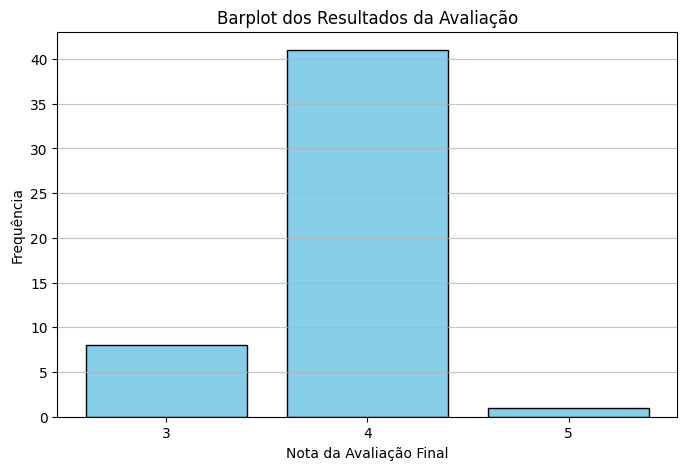

In [6]:
print("Resultados da avaliação:")
print(eval_results['final_evaluation'].value_counts())

print("\nMédia da avaliação:")
print(eval_results['final_evaluation'].mean())

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
value_counts = eval_results['final_evaluation'].value_counts().sort_index()
plt.bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black')
plt.title("Barplot dos Resultados da Avaliação")
plt.xlabel("Nota da Avaliação Final")
plt.ylabel("Frequência")
plt.grid(axis='y', alpha=0.75)
plt.show()


À partir do gráfico acima, percebe-se que houve, na mensuração artificial, um entendimento mínimo de cada uma das personas, conforme a própria avaliação.

Contudo, existem diversas limitações no modelo de avaliação, em especial pelo uso de um mesmo modelo de LLM tanto para perguntas, respostas e avaliações. 

Com isso, deve-se pensar, para uma próxima iteração sobre o sistema, uma forma melhor de avaliação automatizada, preferencialmente usando um modelo de machine learning próprio com aprendizagem de máquina semi-supervisionada. 
